In [127]:
'''
dyn_sys = 'pendulum' 
dyn_sys = 'linear_spring_mass'
dyn_sys = 'nonlinear_spring_mass'
are three valid values that the variable dyn_sys can take. 

Any other string throws an error as they are not defined.
Switch from one to the other to check the performance of the 
Hamiltonian Neural Network on these systems i.e., 
a linear spring mass system, a nolinear spring mass system or a pendulum
'''
dyn_sys = 'linear_spring_mass'

In [128]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

def L2_loss(u, v):
  return (u-v).pow(2).mean()

class MLP(nn.Module):

    def __init__(self, input_dim, output_dim):

        self.input_dim = input_dim
        self.output_dim = output_dim
        super().__init__()
        N = 64
        self.model = nn.Sequential(
          nn.Linear(self.input_dim, N),
          nn.Sigmoid(),
          nn.Linear(N, N),
          nn.Tanh(),
          nn.Linear(N, N),
          nn.Tanh(),
          nn.Linear(N, self.output_dim)
        )

    def forward(self, x):
        '''Forward pass'''
        output = self.model(x)
        return output


class HNN(nn.Module):

    def __init__(self, input_dim, differentiable_model):
        super(HNN, self).__init__()
        self.input_dim = input_dim
        self.differentiable_model = differentiable_model
        self.M = self.permutation_tensor(input_dim)

    def forward(self, x):
        y = self.differentiable_model(x)
        return y

    def time_derivative(self, x, t=None):
        y = self.forward(x) # traditional forward pass
        J_dy = torch.zeros_like(x) # start out with both components set to 0
        dy = torch.autograd.grad(y.sum(), x, create_graph=True)[0] # gradients 
        M = self.permutation_tensor(self.input_dim)
        J_dy = dy @ M

        return J_dy

    def permutation_tensor(self,n):

        M = torch.eye(n)
        M = torch.cat([-M[n//2:], M[:n//2]])

        return M

In [129]:
from IPython.utils.path import errno
import autograd
import autograd.numpy as np

import scipy.integrate
solve_ivp = scipy.integrate.solve_ivp

def hamiltonian_fn(coords):
    '''
    The Hamiltonian functions are defined in a simple way that characterize the system.
    For example in the linear spring mass case the Hamiltonian is obtained by setting the
    mass to be equal to 0.5 unit and the spring constant to be equal to 2.

    In the pendulum case the moment of inertia about the pivot is set to be equal to 0.5 
    and mgl value is set to be equal to 1.
    '''
    q, p = np.split(coords,2)
    if dyn_sys == 'linear_spring_mass':
      H = p**2 + q**2 # spring hamiltonian (linear oscillator) corrsponds to m = 0.5 and k = 2
    elif dyn_sys == 'pendulum':
      H = p**2 - np.cos(q)
    elif dyn_sys == 'nonlinear_spring_mass':
      H = p**2 + q**2 + q**4
    else:
      raise ValueError("model must be either 'spring_mass' or 'pendulum' ")
    return H

def dynamics_fn(t, coords):
    dcoords = autograd.grad(hamiltonian_fn)(coords)
    dqdt, dpdt = np.split(dcoords,2)
    S = np.concatenate([dpdt, -dqdt], axis=-1)
    return S

def get_trajectory(t_span=[0,30], timescale=10, y0=None, noise_std=0.1,**kwargs):
    t_eval = np.linspace(t_span[0], t_span[1], int(timescale*(t_span[1]-t_span[0])))
    
    # get initial state
    if dyn_sys == 'linear_spring_mass':
      if y0 is None:
        y0 = np.random.uniform(-10,10,2) # np.random.rand(2)*2-1
    elif dyn_sys == 'pendulum' or dyn_sys == 'nonlinear_spring_mass':
      if y0 is None:
        y0 = np.random.uniform(-1,1,2) # np.random.rand(2)*2-1

    spring_ivp = solve_ivp(fun=dynamics_fn, t_span=t_span, y0=y0, t_eval=t_eval, rtol=1e-10, **kwargs)
    q, p = spring_ivp['y'][0], spring_ivp['y'][1]
    dydt = [dynamics_fn(None, y) for y in spring_ivp['y'].T]
    dydt = np.stack(dydt).T
    dqdt, dpdt = np.split(dydt,2)
    
    # add noise
    q += np.random.randn(*q.shape)*noise_std
    p += np.random.randn(*p.shape)*noise_std
    return q, p, dqdt, dpdt, t_eval

def get_dataset(seed=0, samples=50, test_split=0.5,  **kwargs):
    data = {'meta': locals()}

    # randomly sample inputs
    np.random.seed(seed)
    xs, dxs, ts = [], [], []
    for s in range(samples):
        x, y, dx, dy, t = get_trajectory(noise_std = 0.0, dyn_sys = dyn_sys,**kwargs)
        xs.append( np.stack( [x, y]).T )
        dxs.append( np.stack( [dx, dy]).T )
        ts.append(t)
    data['x'] = np.concatenate(xs)
    data['dx'] = np.concatenate(dxs).squeeze()
    data['t'] = np.concatenate(ts).squeeze()
    # make a train/test split
    split_ix = int(len(data['x']) * test_split)
    split_data = {}
    for k in ['x', 'dx','t']:
        split_data[k], split_data['test_' + k] = data[k][:split_ix], data[k][split_ix:]
    data = split_data
    return data

In [130]:
numSamples = 5
total_steps = 1000

nn_model = MLP(2, 1)
model = HNN(2, differentiable_model=nn_model)
optim = torch.optim.Adam(model.parameters(), lr = 1e-2, weight_decay=1e-4)

# arrange data
data = get_dataset(seed = 5, samples = numSamples, test_split= 0.8)
x = torch.tensor( data['x'], requires_grad=True, dtype=torch.float32)
test_x = torch.tensor( data['test_x'], requires_grad=True, dtype=torch.float32)
dxdt = torch.Tensor(data['dx'])
test_dxdt = torch.Tensor(data['test_dx'])
t = torch.Tensor(data['t'])
test_t  = torch.tensor(data['test_t'])



/usr/local/lib/python3.8/dist-packages/scipy/integrate/_ivp/common.py:39: UserWarning: The following arguments have no effect for a chosen solver: `dyn_sys`.
  warn("The following arguments have no effect for a chosen solver: {}."


In [131]:
# vanilla train loop
stats = {'train_loss': [], 'test_loss': []}
for step in range(total_steps+1):
  
    # train step
    dxdt_hat = model.time_derivative(x)
    loss = L2_loss(dxdt, dxdt_hat)
    loss.backward() ; optim.step() ; optim.zero_grad()
  
    # run test data
    test_dxdt_hat = model.time_derivative(test_x)
    test_loss = L2_loss(test_dxdt, test_dxdt_hat)

    # logging
    stats['train_loss'].append(loss.item())
    stats['test_loss'].append(test_loss.item())
  
train_dxdt_hat = model.time_derivative(x)
train_dist = (dxdt - train_dxdt_hat)**2
test_dxdt_hat = model.time_derivative(test_x)
test_dist = (test_dxdt - test_dxdt_hat)**2
print('Final train loss {:.4e} +/- {:.4e}\nFinal test loss {:.4e} +/- {:.4e}'
  .format(train_dist.mean().item(), train_dist.std().item()/np.sqrt(train_dist.shape[0]),
          test_dist.mean().item(), test_dist.std().item()/np.sqrt(test_dist.shape[0])))


Final train loss 2.2700e-02 +/- 1.0253e-03
Final test loss 1.8865e-02 +/- 1.9046e-03


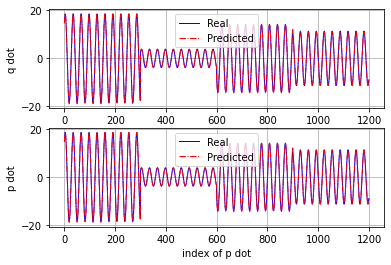

In [132]:
plt.subplot(2,1,1)
plt.plot(dxdt[:int(len(dxdt[:,0])),0],'-b',linewidth = 1)
plt.plot(train_dxdt_hat.detach().numpy()[:int(len(dxdt[:,0])),0],'-.r',linewidth = 1)
plt.xlabel('index of q dot')
plt.ylabel('q dot')
plt.legend(['Real','Predicted'])
plt.grid()

plt.subplot(2,1,2)
plt.plot(dxdt[:int(len(dxdt[:,0])),0],'-b',linewidth = 1)
plt.plot(train_dxdt_hat.detach().numpy()[:int(len(dxdt[:,0])),0],'-.r',linewidth = 1)
plt.xlabel('index of p dot')
plt.ylabel('p dot')
plt.legend(['Real','Predicted'])
plt.grid()

plt.show()

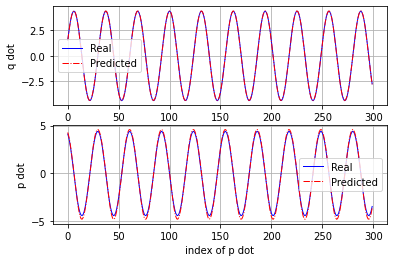

In [133]:
plt.subplot(2,1,1)
plt.plot(test_dxdt[:,0],'-b',linewidth = 1)
plt.plot(test_dxdt_hat.detach().numpy()[:,0],'-.r',linewidth = 1)
plt.xlabel('index of q dot')
plt.ylabel('q dot')
plt.legend(['Real','Predicted'])
plt.grid()

plt.subplot(2,1,2)
plt.plot(test_dxdt[:,1],'-b',linewidth = 1)
plt.plot(test_dxdt_hat.detach().numpy()[:,1],'-.r',linewidth = 1)
plt.xlabel('index of p dot')
plt.ylabel('p dot')
plt.legend(['Real','Predicted'])
plt.grid()

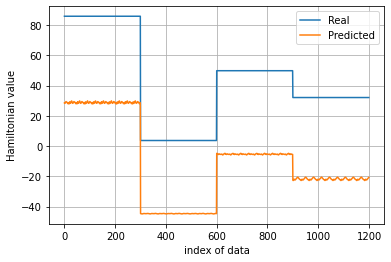

In [134]:
if dyn_sys == 'linear_spring_mass':
  plt.plot(data['x'][:,1]**2+data['x'][:,0]**2) #-85.8921-7.7260
elif dyn_sys == 'pendulum':
  plt.plot(data['x'][:,1]**2-np.cos(data['x'][:,0])) #-85.8921-7.7260
elif dyn_sys == 'nonlinear_spring_mass':
  plt.plot(data['x'][:,1]**2+data['x'][:,0]**2+data['x'][:,0]**4) #-85.8921-7.7260

plt.plot(model.forward(x).detach().numpy())
plt.xlabel('index of data')
plt.ylabel('Hamiltonian value')
plt.legend(['Real','Predicted'])
plt.legend(['Real','Predicted'])
plt.grid()

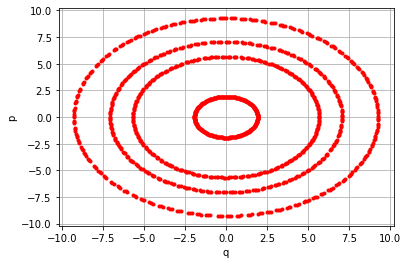

In [135]:
plt.plot(x.detach().numpy()[:,0],x.detach().numpy()[:,1],'.r')
plt.xlabel('q')
plt.ylabel('p')
plt.grid()